In [1]:
import pandas as pd

df = pd.read_excel("Online Retail.xlsx")

In [2]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.isnull().sum()

df = df.dropna(subset=['CustomerID'])

df = df[df['Quantity'] > 0]

In [4]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

In [5]:
import datetime as dt

reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# RFM calculation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'  
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

In [6]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4339.0,92.518322,100.009747,1.0,18.000,51.00,142.00,374.00
Frequency,4339.0,4.271952,7.705493,1.0,1.000,2.00,5.00,210.00
Monetary,4339.0,2053.793018,8988.248381,0.0,307.245,674.45,1661.64,280206.02


In [7]:
rfm = rfm[rfm["Monetary"] > 0]

rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4338.0,92.536422,100.014169,1.00,18.000,51.000,142.00,374.00
Frequency,4338.0,4.272706,7.706221,1.00,1.000,2.000,5.00,210.00
Monetary,4338.0,2054.266460,8989.230441,3.75,307.415,674.485,1661.74,280206.02


In [8]:
rfm["recency_score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1])

#Calculation of the Frequency Score
#rank usage: it is a method for assigning a value to multiple repeated expressions (a value falling into 2 different categories, etc.).
rfm["frequency_score"] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

#Calculating the Monetary Score
rfm["monetary_score"] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

#Calculation of the RF Score
rfm["RF_SCORE"] = (rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str))

# View of Dataframe
rfm.head(10)

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RF_SCORE
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,5,11
12347.0,2,7,4310.00,5,5,5,55
12348.0,75,4,1797.24,2,4,4,24
12349.0,19,1,1757.55,4,1,4,41
12350.0,310,1,334.40,1,1,2,11
12352.0,36,8,2506.04,3,5,5,35
12353.0,204,1,89.00,1,1,1,11
12354.0,232,1,1079.40,1,1,4,11
12355.0,214,1,459.40,1,1,2,11


**RFM-Based Segmentation**

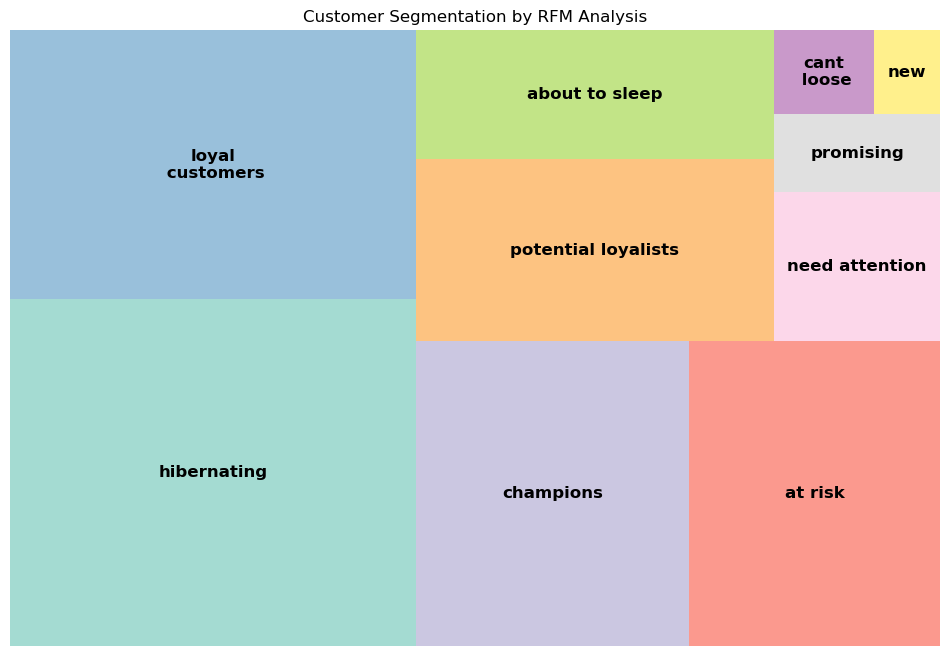

In [9]:
import pandas as pd
import squarify
import matplotlib.pyplot as plt

seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'cant\n loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal\n customers',
    r'41': 'promising',
    r'51': 'new',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm['segment'] = rfm['RF_SCORE'].replace(seg_map, regex=True)

segment_sizes = rfm['segment'].value_counts()

segments = segment_sizes.index.tolist()
sizes = segment_sizes.values
colors = ['#8dd3c7', '#80b1d3', '#bebada', '#fb8072', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ffed6f'] 

plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=segments, color=colors[:len(segments)], alpha=0.8, text_kwargs={'fontsize': 12, 'weight': 'bold'})
plt.axis('off')
plt.title("Customer Segmentation by RFM Analysis")
plt.show()


**Treemap of Customer Segments (RFM Analysis):**

This treemap visually represents different customer segments like Loyal Customers, Champions, Potential Loyalists, etc., based on RFM scores. Each segment is represented by a unique color and positioned in the grid, showing the distribution of different customer types.

**Key Focus Segments:**
Champions: High Recency, Frequency, and Monetary scores. These are high-value customers that businesses should focus on retaining.

Loyal Customers: They make frequent purchases, though they may not be the most recent or highest spenders. Offering loyalty rewards could help retain them.

Potential Loyalists: They have potential to become loyal but might need additional engagement.

At Risk and Hibernating: These customers show lower recent engagement and may need reactivation strategies.


**Different Clustering Techniques**

In [16]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score

In [20]:
# Define parameter grids for each model
param_grids = {
    'KMeans': {
        'n_clusters': [4, 5, 6, 7, 8],
        'random_state': [42]
    },
    'DBSCAN': {
        'eps': [0.3, 0.5, 0.7],
        'min_samples': [5, 10, 15]
    },
    'Agglomerative': {
        'n_clusters': [4, 5, 6, 7, 8],
        'linkage': ['ward', 'complete', 'average']
    },
    'GMM': {
        'n_components': [4, 5, 6, 7, 8],
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'random_state': [42]
    }
}


In [33]:
# Standardize the RFM data for clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

def tune_clustering(X, model, param_grid):
    best_score = -1
    best_model = None
    best_params = None
    for params in ParameterGrid(param_grid):
        model.set_params(**params)
        if hasattr(model, 'fit_predict'):
            labels = model.fit_predict(X)
        else:
            model.fit(X)
            labels = model.predict(X)
        if len(set(labels)) > 1:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_model = model
                best_params = params
    return best_model, best_score, best_params

# Dictionary to store the best models, scores, and parameters
best_models = {}
best_scores = {}
best_params = {}

# 1. KMeans Clustering
kmeans = KMeans()
best_kmeans, score_kmeans, params_kmeans = tune_clustering(rfm_scaled, kmeans, param_grids['KMeans'])
best_models['KMeans'] = best_kmeans
best_scores['KMeans'] = score_kmeans
best_params['KMeans'] = params_kmeans

# 2. DBSCAN Clustering
dbscan = DBSCAN()
best_dbscan, score_dbscan, params_dbscan = tune_clustering(rfm_scaled, dbscan, param_grids['DBSCAN'])
best_models['DBSCAN'] = best_dbscan
best_scores['DBSCAN'] = score_dbscan
best_params['DBSCAN'] = params_dbscan

# 3. Agglomerative Clustering
agglo = AgglomerativeClustering()
best_agglo, score_agglo, params_agglo = tune_clustering(rfm_scaled, agglo, param_grids['Agglomerative'])
best_models['Agglomerative'] = best_agglo
best_scores['Agglomerative'] = score_agglo
best_params['Agglomerative'] = params_agglo

# 4. Gaussian Mixture Model (GMM)
gmm = GaussianMixture()
best_gmm, score_gmm, params_gmm = tune_clustering(rfm_scaled, gmm, param_grids['GMM'])
best_models['GMM'] = best_gmm
best_scores['GMM'] = score_gmm
best_params['GMM'] = params_gmm

# Display the best scores and parameters
for model_name in best_models:
    print(f"{model_name}: Best Score = {best_scores[model_name]}, Best Params = {best_params[model_name]}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

KMeans: Best Score = 0.6162737780729131, Best Params = {'n_clusters': 5, 'random_state': 42}
DBSCAN: Best Score = 0.8549303471633773, Best Params = {'eps': 0.7, 'min_samples': 5}
Agglomerative: Best Score = 0.9077776809582176, Best Params = {'linkage': 'average', 'n_clusters': 4}
GMM: Best Score = 0.6170468524531865, Best Params = {'covariance_type': 'tied', 'n_components': 5, 'random_state': 42}


In [34]:
# Applying the best models to create clusters
rfm['KMeans_Cluster'] = best_models['KMeans'].fit_predict(rfm_scaled)
rfm['DBSCAN_Cluster'] = best_models['DBSCAN'].fit_predict(rfm_scaled)
rfm['Agglomerative_Cluster'] = best_models['Agglomerative'].fit_predict(rfm_scaled)
rfm['GMM_Cluster'] = best_models['GMM'].predict(rfm_scaled)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [36]:
# Create cross-tabulations to compare RFM segments with clustering-based segments
kmeans_crosstab = pd.crosstab(rfm['segment'], rfm['KMeans_Cluster'])
dbscan_crosstab = pd.crosstab(rfm['segment'], rfm['DBSCAN_Cluster'])
agglo_crosstab = pd.crosstab(rfm['segment'], rfm['Agglomerative_Cluster'])
gmm_crosstab = pd.crosstab(rfm['segment'], rfm['GMM_Cluster'])

# Display the cross-tabulations for each clustering method
print("KMeans vs RFM Segments:\n", kmeans_crosstab)
print("DBSCAN vs RFM Segments:\n", dbscan_crosstab)
print("Agglomerative vs RFM Segments:\n", agglo_crosstab)
print("GMM vs RFM Segments:\n", gmm_crosstab)


KMeans vs RFM Segments:
 KMeans_Cluster         0    1   2  3  4    5    6    7
segment                                               
about to sleep         0  351   0  0  0    0    0    0
at risk               88  158   0  0  0    0    0  334
cant\n loose           4   12   0  0  0    2   20   25
champions              0  187  17  2  3  103  321    0
hibernating          516  156   1  0  0    0    0  392
loyal\n customers      0  478   3  0  0   25  321    0
need attention         0  185   0  0  0    0    1    0
new                    0   42   0  0  0    0    0    0
potential loyalists    0  491   0  0  1    0    0    0
promising              0   99   0  0  0    0    0    0
DBSCAN vs RFM Segments:
 DBSCAN_Cluster       -1     0
segment                      
about to sleep        0   351
at risk               2   578
cant\n loose          2    61
champions            43   590
hibernating           2  1063
loyal\n customers     8   819
need attention        0   186
new                 

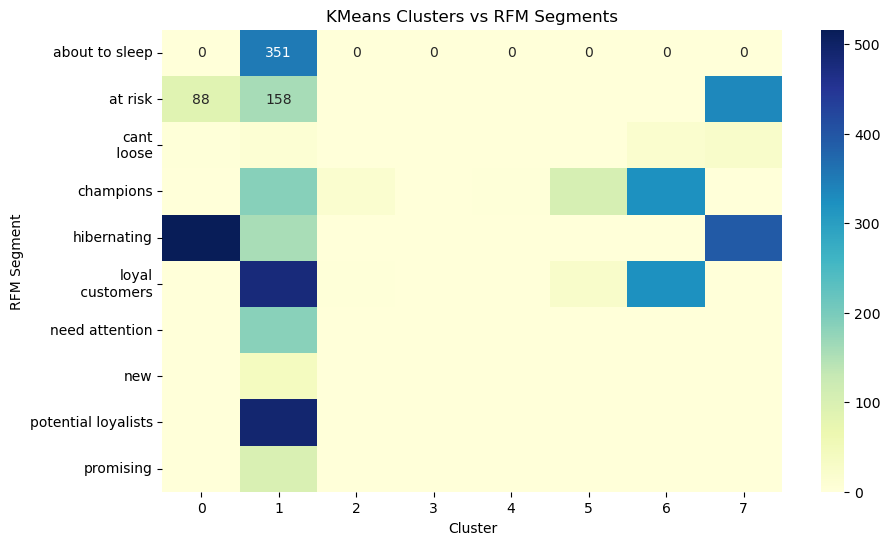

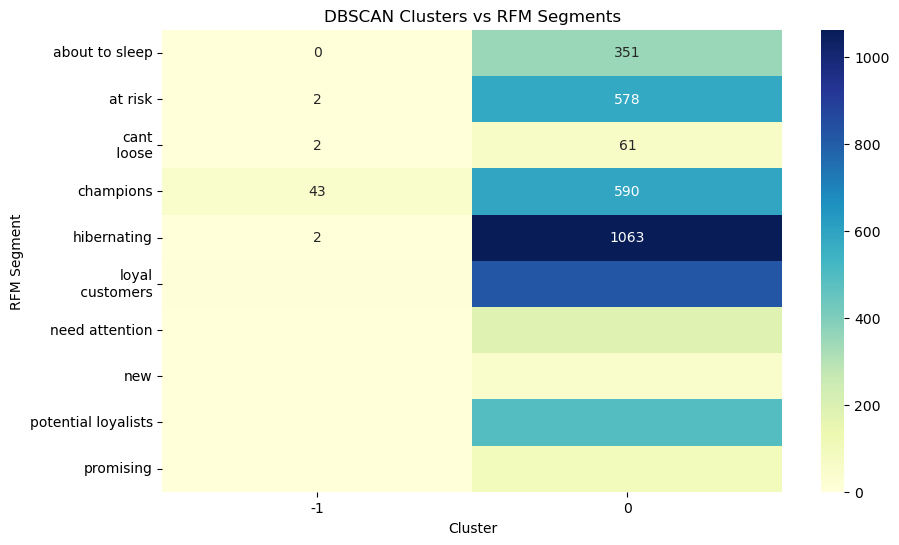

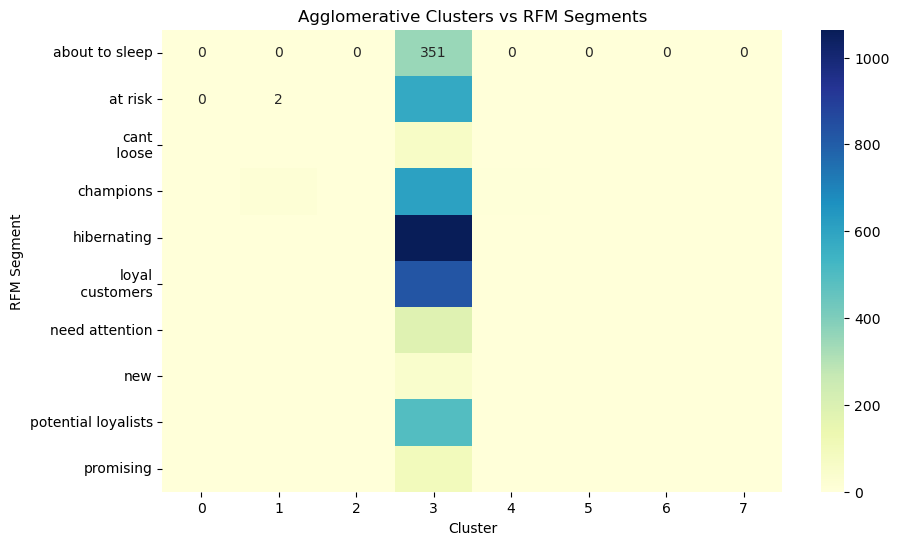

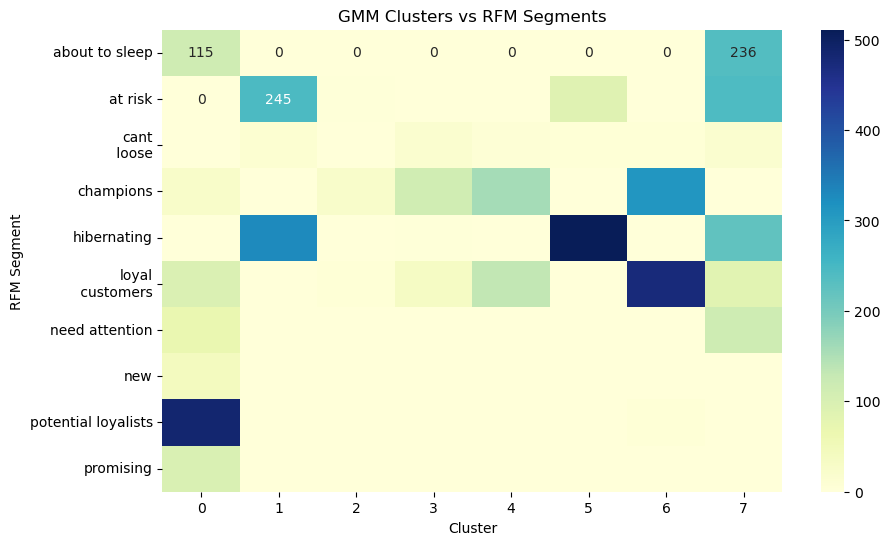

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_crosstab_heatmap(crosstab, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(crosstab, annot=True, cmap="YlGnBu", fmt="d")
    plt.title(title)
    plt.xlabel("Cluster")
    plt.ylabel("RFM Segment")
    plt.show()

# Plotting heatmaps for each clustering method
plot_crosstab_heatmap(kmeans_crosstab, "KMeans Clusters vs RFM Segments")
plot_crosstab_heatmap(dbscan_crosstab, "DBSCAN Clusters vs RFM Segments")
plot_crosstab_heatmap(agglo_crosstab, "Agglomerative Clusters vs RFM Segments")
plot_crosstab_heatmap(gmm_crosstab, "GMM Clusters vs RFM Segments")

### 1. **KMeans Clustering**

- **Observation**: KMeans shows some distribution across different clusters, particularly for segments like "champions" and "loyal customers." For instance:
  - "Champions" are spread across clusters 1, 5, and 6, indicating variability within this high-value group.
  - "Loyal customers" are split between clusters 1 and 6.
- **Interpretation**: This spread suggests that KMeans may be capturing sub-groups within RFM segments, particularly in the "champions" and "loyal customers" segments. This could add value by identifying high-value customers with different spending patterns.

### 2. **DBSCAN Clustering**

- **Observation**: DBSCAN clustering shows two main groups:
  - Most customers are in **Cluster 0**.
  - A small number of customers are in **Cluster -1** (noise points).
- **Interpretation**: DBSCAN might not be ideal here since it primarily groups customers into one large cluster and labels a few as noise. This lack of differentiation indicates that DBSCAN may not be adding value beyond RFM segmentation.

### 3. **Agglomerative Clustering**

- **Observation**: Agglomerative clustering has grouped almost all segments into **Cluster 3**:
  - Most RFM segments like "hibernating," "loyal customers," and "at risk" are all placed in Cluster 3.
  - Only a few customers from "champions" are scattered across other clusters.
- **Interpretation**: Like DBSCAN, Agglomerative Clustering does not appear to be capturing distinct segments beyond what RFM already provides. Most customers end up in one large cluster, which may not provide additional actionable insights.

### 4. **Gaussian Mixture Model (GMM)**

- **Observation**: GMM has a broader distribution across clusters:
  - "Champions" are spread across clusters 2, 3, 4, and 6, showing some level of differentiation within this group.
  - "Loyal customers" are primarily in clusters 0, 4, and 6, suggesting that GMM identifies different spending or frequency patterns within this group.
- **Interpretation**: GMM shows the most variation among clusters, particularly for "champions" and "loyal customers." This could be useful if the goal is to further segment high-value customers, as GMM may reveal sub-segments based on spending habits.

### Summary of Comparison

| Model            | Strengths                                         | Limitations                                              |
|------------------|---------------------------------------------------|----------------------------------------------------------|
| **KMeans**       | Captures some sub-groups within high-value RFM segments like "champions" and "loyal customers." | Limited differentiation for low-value segments (e.g., "hibernating"). |
| **DBSCAN**       | Identifies noise points (e.g., outliers)          | Clusters almost all customers into a single cluster, limiting insights. |
| **Agglomerative**| Simple structure, but lacks granularity           | Similar to DBSCAN, with most customers in one large cluster. |
| **GMM**          | Shows good variation across high-value segments; clusters "champions" and "loyal customers" distinctly | May be more complex to interpret, but provides detailed segmentation for high-value customers. |


Given the above findings, 

1. **We can use RFM Segmentation as the Foundation**:
   - RFM segmentation effectively categorizes customers into actionable segments, such as "champions," "at risk," and "hibernating," based on well-defined metrics.

2. **Leverage GMM or KMeans for High-Value Segments**:
   - Use **GMM** or **KMeans** to further segment **"champions"** and **"loyal customers"** into sub-groups. This can provide additional insights into spending patterns, allowing for more targeted strategies.
   - For example, within "champions," we might find different sub-groups with varying frequency and monetary scores. This could help tailor loyalty programs specifically for sub-groups.

In [43]:
high_value_customers = high_value_customers.copy()  
high_value_customers['GMM_Sub_Cluster'] = gmm_high_value.fit_predict(high_value_scaled)

sub_cluster_summary = high_value_customers.groupby(['segment', 'GMM_Sub_Cluster']).mean(numeric_only=True)
print(sub_cluster_summary)

                            Recency   Frequency       Monetary       PCA1  \
segment   GMM_Sub_Cluster                                                   
champions 0                5.957377   10.254098    4042.892590   0.993166   
          1                3.666667   60.000000  244804.703333  22.292455   
          2                4.055556   56.333333   53497.210000   8.516063   
          3                1.000000  205.500000   88772.395000  24.079512   

                                PCA2   Cluster  KMeans_Cluster  \
segment   GMM_Sub_Cluster                                        
champions 0                -0.591991  0.000000        4.300000   
          1                11.046213  2.666667        4.000000   
          2                 2.401050  0.222222        2.166667   
          3                 6.516412  1.000000        3.000000   

                           DBSCAN_Cluster  Agglomerative_Cluster  GMM_Cluster  
segment   GMM_Sub_Cluster                                   

Text(0, 0.5, 'PCA2')

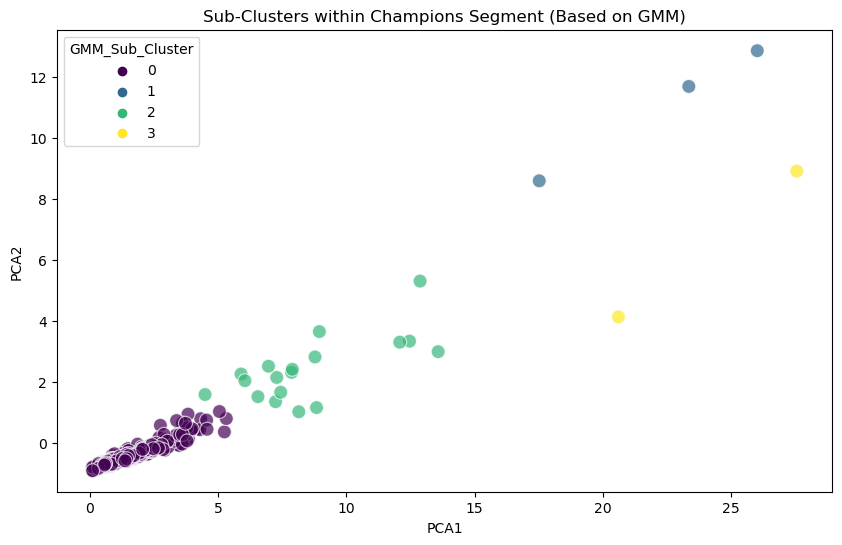

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for champions sub-clusters based on PCA1 and PCA2
plt.figure(figsize=(10, 6))
sns.scatterplot(data=high_value_customers, x='PCA1', y='PCA2', hue='GMM_Sub_Cluster', palette='viridis', s=100, alpha=0.7)
plt.title("Sub-Clusters within Champions Segment (Based on GMM)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

We have successfully segmented the **"champions"** group further using **GMM (Gaussian Mixture Model)** and generated **sub-clusters**. Here’s an analysis of each sub-cluster within the "champions" segment and insights for potential business actions:

### Analysis of "Champions" Sub-Clusters

The **"champions"** segment is divided into four sub-clusters (0, 1, 2, and 3), each with distinct characteristics in terms of **Recency**, **Frequency**, and **Monetary** values.

| Sub-Cluster | Recency (Low = recent) | Frequency | Monetary       | Insights and Potential Actions                             |
|-------------|-------------------------|-----------|----------------|------------------------------------------------------------|
| **0**       | 5.96                    | 10.25     | 4,042.89       | **Less frequent but high-value recent buyers**. These customers could be encouraged to purchase more frequently with loyalty rewards or targeted offers. |
| **1**       | 3.67                    | 60.00     | 244,804.70     | **Very high spenders and moderate recency**. These are ultra-high-value customers. Offer personalized, premium services or exclusive products to reinforce loyalty. |
| **2**       | 4.06                    | 56.33     | 53,497.21      | **High frequency and medium spend**. These are loyal, consistent buyers. Continue engaging with loyalty rewards and encourage upselling. |
| **3**       | 1.00                    | 205.50    | 88,772.40      | **Very frequent buyers and relatively high spenders**. These are the most engaged and frequent customers. Maintain engagement with personalized offers and high-quality customer service. |

### Additional Metrics

The **PCA1 and PCA2** values indicate the principal components, which provide an abstract way of visualizing the spread of these sub-clusters in two dimensions. This could be useful if you plan to create a visual scatter plot of the clusters.

### Interpretation and Actions

1. **Sub-Cluster 0**: These customers are recent buyers with lower frequency but notable spending. They might respond well to campaigns that increase their purchase frequency, like loyalty rewards for regular purchases or limited-time offers.

2. **Sub-Cluster 1**: This is a very high-value group in terms of monetary spending. Focus on providing a premium experience, personalized product recommendations, and possibly even a dedicated customer service channel.

3. **Sub-Cluster 2**: These customers are loyal and buy frequently but with a more moderate spend compared to Sub-Cluster 1. Consider upselling or cross-selling strategies to increase their monetary value.

4. **Sub-Cluster 3**: These are your most frequent buyers with substantial spending. Maintaining engagement and loyalty through exclusive benefits, early access to new products, and customer appreciation events could help retain this group.

### Comparing Cluster Labels Across Models

The table includes additional columns for **Cluster labels from other models (KMeans, DBSCAN, Agglomerative, GMM)**. Here’s how these labels might inform our strategy:

- **Consistency of Clustering**: Sub-cluster 1 within "champions" has consistent high values across different models, indicating it's a stable group of ultra-high-value customers.
- **Variability**: Other clusters show some variability across different models (e.g., KMeans_Cluster and DBSCAN_Cluster), which might highlight how different algorithms interpret their behaviors. You may want to select the clustering model that best aligns with our business objectives or use this variability to tailor different engagement strategies.

### Summary

1. **Segmentation**: The "champions" group has been divided into four sub-clusters, each with unique spending and engagement characteristics.
2. **Actions**: Tailored engagement strategies can be developed for each sub-cluster to maximize their lifetime value. For instance:
   - **Sub-Cluster 1**: Premium services and exclusive offers.
   - **Sub-Cluster 3**: Frequent, personalized communication and loyalty incentives.
3. **Validation with Other Models**: The comparison across different clustering labels shows that some sub-clusters are more stable (e.g., Sub-Cluster 1), while others vary, offering additional insights for nuanced customer strategies.

## Validation

In [49]:
df = pd.read_csv('retail_sales_dataset.csv')
df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [50]:
from datetime import timedelta

df['Date'] = pd.to_datetime(df['Date'])

reference_date = df['Date'].max() + timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'Date': lambda x: (reference_date - x.max()).days,  
    'Transaction ID': 'nunique',                         
    'Total Amount': 'sum'                                
}).rename(columns={'Date': 'Recency', 'Transaction ID': 'Frequency', 'Total Amount': 'Monetary'}).reset_index()

# Display the RFM DataFrame
rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,CUST001,39,1,150
1,CUST002,309,1,1000
2,CUST003,354,1,30
3,CUST004,226,1,500
4,CUST005,241,1,100


In [51]:
rfm['recency_score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['frequency_score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm['monetary_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm['RFM_Segment'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str)

rfm.head()

,Customer ID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_Segment
0,CUST001,39,1,150,5,1,3,51
1,CUST002,309,1,1000,1,1,4,11
2,CUST003,354,1,30,1,1,1,11
3,CUST004,226,1,500,2,1,4,21
4,CUST005,241,1,100,2,1,2,21


In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

high_value_customers = rfm[rfm['RFM_Segment'].isin(['55', '54', '53'])]
scaler = StandardScaler()
high_value_scaled = scaler.fit_transform(high_value_customers[['Recency', 'Frequency', 'Monetary']])

gmm = GaussianMixture(n_components=4, covariance_type='tied', random_state=42)
high_value_customers['GMM_Sub_Cluster'] = gmm.fit_predict(high_value_scaled)

high_value_customers.head()

/var/folders/yr/9f2qzmnx46z8rplnf17bhnkw0000gn/T/ipykernel_8594/1764848630.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_value_customers['GMM_Sub_Cluster'] = gmm.fit_predict(high_value_scaled)


,Customer ID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_Segment,GMM_Sub_Cluster
405,CUST405,57,1,1200,5,3,5,53,3
409,CUST409,15,1,900,5,3,4,53,0
410,CUST410,42,1,100,5,3,2,53,2
417,CUST417,42,1,900,5,3,4,53,3
424,CUST424,40,1,1200,5,3,5,53,3


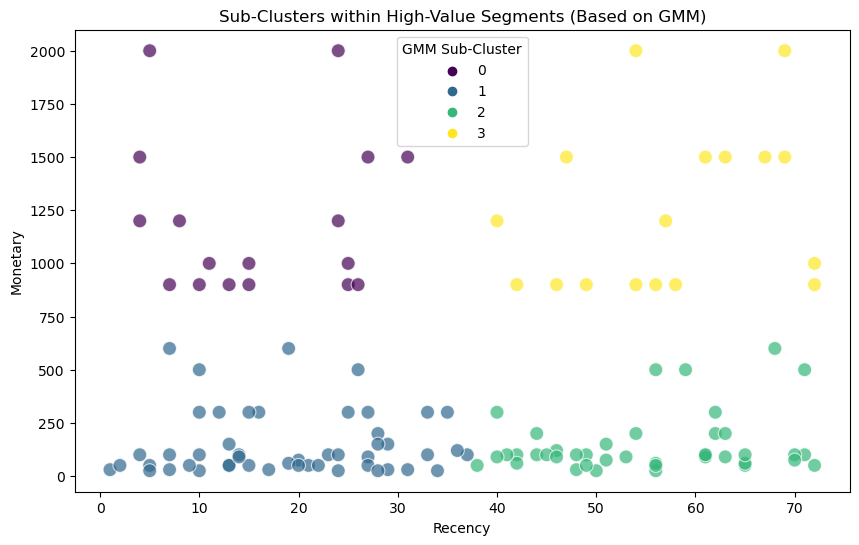

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=high_value_customers, x='Recency', y='Monetary', hue='GMM_Sub_Cluster', palette='viridis', s=100, alpha=0.7)
plt.title("Sub-Clusters within High-Value Segments (Based on GMM)")
plt.xlabel("Recency")
plt.ylabel("Monetary")
plt.legend(title="GMM Sub-Cluster")
plt.show()


In [70]:
import gradio as gr
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import pandas as pd
import os

def load_data(file):
    # Ensure the file is not None
    if file is None:
        raise ValueError("No file uploaded. Please upload a CSV or XLSX file.")

    # Determine file type and load accordingly
    file_extension = os.path.splitext(file.name)[-1].lower()
    if file_extension == '.csv':
        df = pd.read_csv(file.name)
    elif file_extension == '.xlsx':
        df = pd.read_excel(file.name)
    else:
        raise ValueError("Unsupported file format. Please upload a CSV or XLSX file.")
    
    return df

def analyze_customer_segments(file):
    # Load the dataset
    df = load_data(file)
    
    # Check for date column and parse it
    date_col = 'Date' if 'Date' in df.columns else 'InvoiceDate' if 'InvoiceDate' in df.columns else None
    if date_col:
        df[date_col] = pd.to_datetime(df[date_col])
    else:
        raise ValueError("Date column not found. Please ensure 'Date' or 'InvoiceDate' is present.")

    # Calculate reference date for Recency
    reference_date = df[date_col].max() + timedelta(days=1)

    # Determine column names for grouping
    customer_col = 'Customer ID' if 'Customer ID' in df.columns else 'CustomerID'
    transaction_col = 'Transaction ID' if 'Transaction ID' in df.columns else 'InvoiceNo'
    total_amount_col = 'Total Amount' if 'Total Amount' in df.columns else 'TotalPrice'

    # Calculate 'TotalPrice' if necessary
    if total_amount_col not in df.columns:
        if 'Quantity' in df.columns and 'UnitPrice' in df.columns:
            df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
            total_amount_col = 'TotalPrice'
        else:
            raise ValueError("Columns for calculating 'TotalPrice' not found. Ensure 'Quantity' and 'UnitPrice' are present.")

    # Calculate RFM metrics
    rfm = df.groupby(customer_col).agg({
        date_col: lambda x: (reference_date - x.max()).days,
        transaction_col: 'nunique',
        total_amount_col: 'sum'
    }).rename(columns={date_col: 'Recency', transaction_col: 'Frequency', total_amount_col: 'Monetary'}).reset_index()

    # Continue with RFM scoring and segmentation
    rfm['recency_score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
    rfm['frequency_score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5]).astype(int)
    rfm['monetary_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)
    rfm['RFM_Segment'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str)

    # Map RFM segments to meaningful labels
    seg_map = {
        r'[1-2][1-2]': 'Hibernating',
        r'[1-2][3-4]': 'At Risk',
        r'[1-2]5': "Can't Lose",
        r'3[1-2]': 'About to Sleep',
        r'33': 'Need Attention',
        r'[3-4][4-5]': 'Loyal Customers',
        r'41': 'Promising',
        r'51': 'New Customers',
        r'[4-5][2-3]': 'Potential Loyalists',
        r'5[4-5]': 'Champions'
    }
    rfm['RFM_Segment_Label'] = rfm['RFM_Segment'].replace(seg_map, regex=True)

    # Summary of RFM segmentation
    rfm_summary = rfm['RFM_Segment_Label'].value_counts().reset_index()
    rfm_summary.columns = ['Segment', 'Customer Count']

    # Create and save the treemap of RFM segments
    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=rfm_summary['Customer Count'], label=rfm_summary['Segment'], alpha=0.8, color=sns.color_palette("Set3"))
    plt.title("RFM Segment Treemap")
    plt.axis('off')
    plt.savefig("rfm_treemap.png")
    
    # Filter high-value segments and create a copy to avoid warnings
    high_value_customers = rfm[rfm['RFM_Segment_Label'].isin(['Champions', 'Loyal Customers'])].copy()

    # Scale the RFM features for clustering
    scaler = StandardScaler()
    high_value_scaled = scaler.fit_transform(high_value_customers[['Recency', 'Frequency', 'Monetary']])

    # Apply Gaussian Mixture Model for clustering
    gmm = GaussianMixture(n_components=4, covariance_type='tied', random_state=42)
    high_value_customers['GMM_Sub_Cluster'] = gmm.fit_predict(high_value_scaled)

    # Plotting the sub-clusters within high-value segments
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=high_value_customers, x='Recency', y='Monetary', hue='GMM_Sub_Cluster', palette='viridis', s=100, alpha=0.7)
    plt.title("Sub-Clusters within High-Value Segments")
    plt.xlabel("Recency")
    plt.ylabel("Monetary")
    plt.legend(title="GMM Sub-Cluster")
    plt.savefig("sub_clusters_plot.png")  # Save plot as an image
    
    # Exclude non-numeric columns before calculating the mean
    columns_to_drop = [col for col in ['Customer ID', 'CustomerID', 'RFM_Segment', 'RFM_Segment_Label'] if col in high_value_customers.columns]
    sub_cluster_summary = high_value_customers.drop(columns=columns_to_drop).groupby(['GMM_Sub_Cluster']).mean()
    
    return rfm_summary, sub_cluster_summary, "rfm_treemap.png", "sub_clusters_plot.png"

# Define the Gradio interface
interface = gr.Interface(
    fn=analyze_customer_segments,
    inputs="file",
    outputs=["dataframe", "dataframe", "image", "image"],
    title="Customer Segmentation Analysis",
    description="Upload a CSV or XLSX file to perform RFM segmentation and clustering analysis."
)

interface.launch()


* Running on local URL:  http://127.0.0.1:7873

To create a public link, set `share=True` in `launch()`.


**Rely Primarily on RFM Segmentation**

Since clustering has not provided distinct groups, the RFM segments may be more reliable and actionable.

RFM segments already capture specific customer types like "champions," "at risk," and "hibernating," which are valuable for targeted marketing.